In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
imagePaths = list(paths.list_images("/content/drive/MyDrive/dataset"))
data = []
labels = []

In [3]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath,target_size=(224,224))
	print(image)
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2CB326BF10>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D451BCFA0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D441887C0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D44164AC0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D44164610>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D44164AC0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D44164610>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D44164AC0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2CB326B6D0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D44174A60>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D44188A90>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2CB326B6D0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D45FCD280>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2D45FCD280>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2CB326B730>
<PIL.Image.Image image mode=RGB size=224

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [5]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [6]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


9406464/9406464 [==============================] - 0s 0us/step


In [7]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [10]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

INIT_LR= 1e-4
EPOCHS = 5
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [12]:
# train the head of the network


# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("facemodel", save_format="h5")


[INFO] evaluating network...
1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

        acne       0.75      1.00      0.86         3
 withoutAcne       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

[INFO] saving mask detector model...


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2

In [19]:
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/MyDrive/acne_detection/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/acne_detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)


[INFO] loading face detector model...


In [23]:
# load the face mask detector model from disk
print("[INFO] loading face acne detector model...")
model = load_model("/content/drive/MyDrive/acne_detection/facemodel.model")

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread("/content/drive/MyDrive/acne_detection/Sample.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()


[INFO] loading face acne detector model...
[INFO] computing face detections...


1/1 [==============================] - 0s 171ms/step


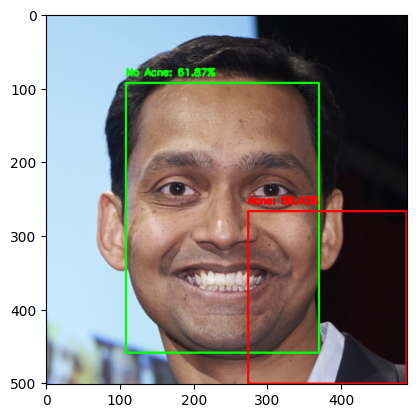

In [24]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a acne or not
		(acne, withoutAcne) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Acne" if acne > withoutAcne else "No Acne"
		color = (0, 0, 255) if label == "Acne" else (0, 255, 0)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(acne, withoutAcne) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
plt.imshow((cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
plt.show()